In [ ]:
!nvidia-smi

Fri Apr 23 01:53:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
import cv2
from matplotlib import pyplot as plt
from glob import glob
import os
from bs4 import BeautifulSoup as bs
import time
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU, ReLU, Dropout, concatenate
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization

Mounted at /content/drive/
     |████████████████████████████████| 706kB 18.1MB/s 


In [ ]:
!mkdir -p ~/.kaggle
!mkdir dataset2
#upload kaggle.json manually
!cp ./dataset2/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

!unzip animal-image-datasetdog-cat-and-panda.zip -d dataset2
!ls dataset2

Streaming output truncated to the last 5000 lines.
  inflating: dataset2/animals/animals/dogs/dogs_00008.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00009.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00010.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00011.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00012.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00013.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00014.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00015.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00016.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00017.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00018.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00019.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00020.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00021.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_00022.jpg  
  inflating: dataset2/animals/animals/dogs/dogs_0

In [ ]:
def preprocessing(img):
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.blur(img,(5,5))
    img = np.double(img)
    img = cv2.normalize(img, None, 1.0, 0.0, cv2.NORM_MINMAX)
    return img
  
def tampil(img):
  plt.figure(figsize=(10,10))
  plt.axis("off")
  plt.imshow(img,cmap="gray")

In [ ]:
x = []
y = []

limit_data = 2000
idx = 0
for folder in sorted(glob("./dataset2/animals/cats/*")):
  img = cv2.imread(folder)
  img = preprocessing(img)
  x.append(img)
  y.append('a cat')
print(len(x))
for folder in sorted(glob("./dataset2/animals/dogs/*")):
  img = cv2.imread(folder)
  img = preprocessing(img)
  x.append(img)
  y.append('a dog')
print(len(x))
for folder in sorted(glob("./dataset2/animals/panda/*")):
  img = cv2.imread(folder)
  img = preprocessing(img)
  x.append(img)
  y.append('a panda')
print(len(x))


  
x = np.array(x)
y = np.array(y)

1000
2000
3000


In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
y = np.expand_dims(y, axis=1)
y = onehot_encoder.fit_transform(y)

(3000, 128, 128)
(3000, 3)


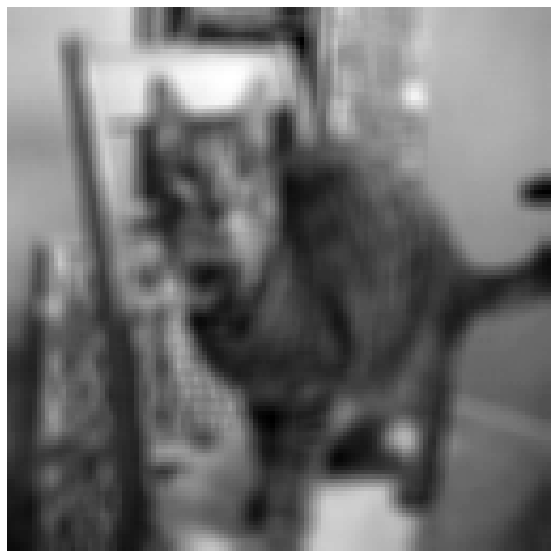

In [ ]:
tampil(x[0])
print(x.shape)
print(y.shape)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
print("Jumlah data    : " + str(x.shape) + " " + str(y.shape))
print("Jumlah training: " + str(x_train.shape) + " " + str(y_train.shape))
print("Jumlah testing : " + str(x_test.shape) + " " + str(y_test.shape))

Jumlah data    : (3000, 128, 128) (3000, 3)
Jumlah training: (2400, 128, 128) (2400, 3)
Jumlah testing : (600, 128, 128) (600, 3)


In [ ]:
augs_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs_gen_val = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [ ]:
from tensorflow.keras import Model, Sequential

model_conv = Sequential()
model_conv.add(Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(3e-5)))
model_conv.add(InstanceNormalization())
model_conv.add(ReLU())
model_conv.add(Dropout(0.3))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(3e-5)))
model_conv.add(InstanceNormalization())
model_conv.add(tf.keras.layers.ReLU())
model_conv.add(Dropout(0.3))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(3e-5)))
model_conv.add(InstanceNormalization())
model_conv.add(tf.keras.layers.ReLU())
model_conv.add(Dropout(0.3))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=l2(3e-5)))
model_conv.add(InstanceNormalization())
model_conv.add(tf.keras.layers.ReLU())
model_conv.add(Dropout(0.3))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(3e-5)))
model_conv.add(InstanceNormalization())
model_conv.add(tf.keras.layers.ReLU())
model_conv.add(Dropout(0.3))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(3e-5)))
model_conv.add(InstanceNormalization())
model_conv.add(tf.keras.layers.ReLU())
model_conv.add(Dropout(0.3))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(3e-5)))
model_conv.add(InstanceNormalization())
model_conv.add(tf.keras.layers.ReLU())
model_conv.add(Dropout(0.3))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(GlobalAveragePooling2D())
model_conv.add(Dense(3, activation='softmax', kernel_regularizer=l2(3e-5)))


optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model_conv.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=["accuracy"])


In [ ]:
print(x_train[0])

[[0.37078652 0.36516854 0.37078652 ... 0.53932584 0.53370787 0.53932584]
 [0.37640449 0.37640449 0.37640449 ... 0.53932584 0.53932584 0.54494382]
 [0.38202247 0.38202247 0.38764045 ... 0.53932584 0.53370787 0.53932584]
 ...
 [0.34831461 0.34831461 0.35955056 ... 0.59550562 0.65168539 0.67977528]
 [0.34831461 0.35393258 0.36516854 ... 0.62359551 0.66292135 0.67977528]
 [0.34831461 0.35393258 0.36516854 ... 0.63483146 0.6741573  0.68539326]]


In [ ]:
batch_size = 32
num_train_samples = len(x_train) / batch_size
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

filepath="/content/gdrive/My Drive/submissionClassification.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
rlrop = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=30)
callbacks_list = [checkpoint, rlrop]
#penggunaan scheduler, malah membuat model terjebak di local minima
history = model_conv.fit(augs_gen.flow(x_train, y_train, batch_size = batch_size, shuffle=True), steps_per_epoch=num_train_samples, epochs=800, 
                    verbose=1, validation_data=(x_test, y_test), callbacks = callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/800
75/75 [==============================] - 8s 74ms/step - loss: 1.9003 - accuracy: 0.3427 - val_loss: 1.2537 - val_accuracy: 0.3133

Epoch 00001: val_accuracy improved from -inf to 0.31333, saving model to /content/gdrive/My Drive/submissionClassification.h5
Epoch 2/800
75/75 [==============================] - 5s 68ms/step - loss: 1.5815 - accuracy: 0.3282 - val_loss: 1.1675 - val_accuracy: 0.3433

Epoch 00002: val_accuracy improved from 0.31333 to 0.34333, saving model to /content/gdrive/My Drive/submissionClassification.h5
Epoch 3/800
75/75 [==============================] - 5s 68ms/step - loss: 1.4966 - accuracy: 0.3420 - val_loss: 1.1293 - val_accuracy: 0.3850

Epoch 00003: val_accuracy improved from 0.34333 to 0.38500, saving model to /content/gdrive/My Drive/submissionClassification.h5
Epoch 4/800
75/75 [==============================] - 5s 68ms/step - loss: 1.4468 - accuracy: 0.3646 - val_loss: 1.1298 - val_accuracy: 0.3867

Epoch 00004: val_accuracy improved from 0.38

In [ ]:
print(model_conv.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, None, None, 32)    320       
_________________________________________________________________
instance_normalization_7 (In (None, None, None, 32)    64        
_________________________________________________________________
re_lu_7 (ReLU)               (None, None, None, 32)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
instance_normalization_8 (In (None, None, None, 64)   

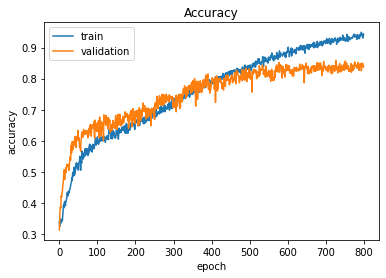

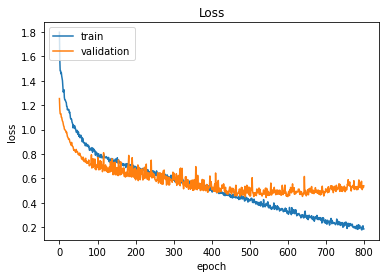

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_conv)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3anr1kdh/assets
